# Simple example of using the `Mf6Cts` package

This notebook will demo a very simple use case of the `Mf6Cts` contaminant treatment system package.

First import the usuals

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy

And we need to get access to the autotesting script and the `Mf6Cts` class itself:

In [2]:
sys.path.append(os.path.join("..","autotest"))
sys.path.append(os.path.join("..","mf6cts"))

In [3]:
import mf6cts

In [4]:
import cts_mf6_test

And we need to know the name of the mf6 shared lib and executable files for the current operating system:

In [5]:
lib_name = cts_mf6_test.lib_name
mf6_bin = cts_mf6_test.mf6_bin

Now we will use a handy-dandy function in the autotest script to setup the flow and transport models for us.  This model will have two CTS instances and each instance will have a time-varying (random) efficiencies centered around the values passed below.  dissolved phase mass will be introduced via the upgradient GHB-type boundary condition

In [6]:
org_sim_ws = "fivespot"
np.random.seed(111)
cts_mf6_test.setup_five_spotish(plot=False, sim_ws=org_sim_ws, simple_pattern=True, eff1=0.5, eff2=0.7, nlay=1,ghb_source=1)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package sto...
    writing package oc...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 6 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 58 based on size of stress_period_data
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000

The flow-model subdirectory:

In [7]:
os.listdir("fivespot")

['gwf.dis_delc.txt',
 'gwf.npf_icelltype.txt',
 'gwf.wel_stress_period_data_7.txt',
 'gwf.wel_stress_period_data_6.txt',
 'gwf.wel_stress_period_data_10.txt',
 'gwf.dis_top.txt',
 'gwf.ghb_stress_period_data_10.txt',
 'gwf.wel_stress_period_data_4.txt',
 'gwf.wel_stress_period_data_5.txt',
 'gwf.dis_delr.txt',
 'gwf_cts_flow_system_summary.csv',
 'gwf.wel_stress_period_data_2.txt',
 'gwf.wel_stress_period_data_3.txt',
 'gwf.npf_k.txt',
 'gwf_cts_flow_node_summary.csv',
 'gwf.ic',
 'gwf.dis_botm.txt',
 'gwf.wel',
 'gwf.hds',
 'gwf.npf_k33.txt',
 'gwf.sto_ss.txt',
 'gwf.npf',
 'gwf.ghb_stress_period_data_8.txt',
 'gwf.sto_iconvert.txt',
 'mf6',
 'gwf.ghb_stress_period_data_9.txt',
 'mfsim.stdout',
 'gwf.ghb_stress_period_data_4.txt',
 'gwf.ghb_stress_period_data_5.txt',
 'gwf.ghb_stress_period_data_7.txt',
 'mfsim.ims',
 'gwf.ghb_stress_period_data_6.txt',
 'gwf.ghb',
 'gwf.ghb_stress_period_data_2.txt',
 'gwf.dis',
 'gwf.ghb_stress_period_data_3.txt',
 'gwf.ghb_stress_period_data_1.txt'

The transport-model subdirectory:

In [8]:
os.listdir("fivespot_t")

['gwt.ic',
 'gwt.mst',
 'gwt.ssm',
 'model.cts',
 'sim.tdis',
 'gwf.hds',
 'gwt.fmi',
 'mf6',
 'gwt.dis',
 'gwt.oc',
 'gwt.cbc',
 'gwt.ims',
 'gwt.adv',
 'mfsim.nam',
 'gwt.lst',
 'gwt.dsp',
 'gwt.ucn',
 'mfsim.lst',
 'gwf.bud',
 'gwt.nam']

Ooohh - let's check out "model.cts"!

In [23]:
lines = open(os.path.join("fivespot_t","model.cts")).readlines()
_ =[print(line.strip()) for line in lines]

begin options

end options

begin period 2 cts 1 efficiency 0.612
wel wel_0 out 1 12 23
wel wel_0 in 1 1 17
end period 2 cts 1

begin period 2 cts 2 efficiency 0.237
wel wel_0 out 1 23 23
wel wel_0 in 1 33 17
wel wel_0 in 1 33 33
wel wel_0 in 1 1 33
end period 2 cts 2

begin period 3 cts 1 efficiency 0.436
wel wel_0 out 1 12 23
wel wel_0 in 1 1 17
end period 3 cts 1

begin period 3 cts 2 efficiency 1.000
wel wel_0 out 1 23 23
wel wel_0 in 1 33 17
wel wel_0 in 1 33 33
wel wel_0 in 1 1 33
end period 3 cts 2

begin period 4 cts 1 efficiency 0.295
wel wel_0 out 1 12 23
wel wel_0 in 1 1 17
end period 4 cts 1

begin period 4 cts 2 efficiency 0.209
wel wel_0 out 1 23 23
wel wel_0 in 1 33 17
wel wel_0 in 1 33 33
wel wel_0 in 1 1 33
end period 4 cts 2

begin period 5 cts 1 efficiency 0.022
wel wel_0 out 1 12 23
wel wel_0 in 1 1 17
end period 5 cts 1

begin period 5 cts 2 efficiency 0.588
wel wel_0 out 1 23 23
wel wel_0 in 1 33 17
wel wel_0 in 1 33 33
wel wel_0 in 1 1 33
end period 5 cts 2

begi

We see the each CTS instance has a period block for each stress period that it is active and the each period block can have an optional efficiency supplied.  Each period block line lists the package type (in this case "wel"), the package instance name ("wel_0"), an in-out flag (either "in" or "out") and then index information that describes where in the model the CTS member is located.  For WEL in structured grids, this is the layer-row-column info.  For WEL in unstructed grids, this is the node number.  For MAW-type boundaries, this is the "welno" value. 

Now lets check out the standard MF6 solution results:

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package ghb...
  loading ims package gwf...


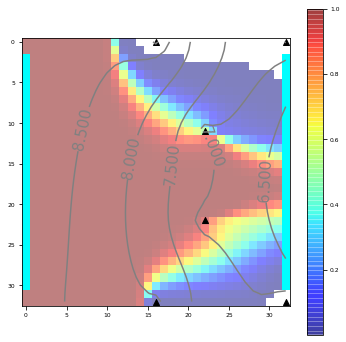

In [9]:
sim = flopy.mf6.MFSimulation.load(sim_ws="fivespot")
m = sim.get_model("gwf")
widx = [i[0] for i in m.get_package("wel").stress_period_data.data[1]]
hds = flopy.utils.HeadFile(os.path.join("fivespot","gwf.hds"))
ucn = flopy.utils.HeadFile(os.path.join("fivespot_t","gwt.ucn"),text="concentration")
fig,ax = plt.subplots(1,1,figsize=(6,6))
carr = ucn.get_data()[0]
carr[carr<=0.0001] = np.nan
c = ax.imshow(carr,cmap="jet",alpha=0.5)
plt.colorbar(c,ax=ax)
lb = ax.contour(hds.get_data()[0],levels=5,colors='0.5')
ax.clabel(lb,fontsize=15)
for w in widx:
    ax.scatter(w[2],w[1],marker="^",c="k")
garr = np.zeros((m.dis.nrow.data,m.dis.ncol.data))
for idx in m.get_package("ghb").stress_period_data.data[1]:
    garr[idx[0][1],idx[0][2]] = idx[2]
garr[garr == 0] = np.nan
ax.imshow(garr,cmap="cool")


The triangles are the WEL locations.  Two extraction wells are shown near the center-right of the model domain, the injections wells are along the edges of the domain.  The effect the of the pump-and-treat system can be seen in the head contours and the concentration distribution.  Remember, this is just the standard MF6 flow and transport solution - no CTS-specific flow balancing or treatment efficiency has been applied.

### CTS time!

First we need to copy the shared MF6 library file to both the flow and transport model directories:

In [10]:
shutil.copy2(lib_name, os.path.join("fivespot_t", os.path.split(lib_name)[-1]))
shutil.copy2(lib_name, os.path.join("fivespot", os.path.split(lib_name)[-1]))

'fivespot/libmf6.so'

Now we can instantiate an `Mf6Cts` instance:

In [11]:
mf = mf6cts.Mf6Cts("model.cts",os.path.split(lib_name)[-1],"fivespot_t","fivespot")

Solve the flow-model, balancing the each CTS instance's extraction vs injection rates:

In [12]:
mf.solve_gwf()

...starting flow solution at 2022-04-12 09:17:23
flow stress period,time step 1,1 converged with 72 iters, took 0.00072418 mins
flow stress period,time step 2,1 converged with 6 iters, took  0.0008618 mins
flow stress period,time step 3,1 converged with 12 iters, took  0.0016632 mins
flow stress period,time step 4,1 converged with 12 iters, took  0.0015819 mins
flow stress period,time step 5,1 converged with 12 iters, took  0.0016394 mins
flow stress period,time step 6,1 converged with 6 iters, took 0.00078905 mins
flow stress period,time step 7,1 converged with 8 iters, took  0.0010449 mins
flow stress period,time step 8,1 converged with 8 iters, took  0.0011334 mins
flow stress period,time step 9,1 converged with 8 iters, took   0.001068 mins
flow stress period,time step 10,1 converged with 8 iters, took  0.0010813 mins

...flow solution finished at 2022-04-12 09:17:24, took:      0.014 mins




Let's inspect some of the CTS-specific CSV files that were created:

In [13]:
pd.read_csv(os.path.join("fivespot","gwf_cts_flow_node_summary.csv"))

,stress_period,time_step,ctime,dt,cts_system,package,instance,inout,index,requested_rate,actual_rate,requested_cum_vol,actual_cum_vol
0,2,1,360.0,180.0,1,wel,wel_0,out,385,-100.000000,-74.884536,-18000.000000,-13479.216485
1,2,1,360.0,180.0,1,wel,wel_0,in,16,100.000000,74.884536,13580.904513,13479.216485
2,2,1,360.0,180.0,2,wel,wel_0,out,748,-100.000000,-73.373202,-18000.000000,-13207.176345
3,2,1,360.0,180.0,2,wel,wel_0,in,1072,33.333333,24.457734,4435.187115,4402.392115
4,2,1,360.0,180.0,2,wel,wel_0,in,1088,33.333333,24.457734,4435.187115,4402.392115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,10,1,1800.0,180.0,1,wel,wel_0,in,16,100.000000,71.686170,118399.341629,12903.510600
266,10,1,1800.0,180.0,2,wel,wel_0,out,748,-100.000000,-70.344005,-162000.000000,-115990.889496
267,10,1,1800.0,180.0,2,wel,wel_0,in,1072,33.333333,23.448002,38698.228328,4220.640304
268,10,1,1800.0,180.0,2,wel,wel_0,in,1088,33.333333,23.448002,38698.228328,4220.640304


In [14]:
pd.read_csv(os.path.join("fivespot","gwf_cts_flow_system_summary.csv"))

,stress_period,time_step,ctime,dt,cts_system,num_injectors,num_extractors,requested_rate,actual_rate,requested_cum_vol,actual_cum_vol
0,2,1,360.0,180.0,1,1,1,100.0,74.884536,-18000.0,13479.216485
1,2,1,360.0,180.0,2,3,1,100.0,73.373202,-18000.0,13207.176345
2,3,1,540.0,180.0,1,1,1,100.0,74.636984,-36000.0,26913.873637
3,3,1,540.0,180.0,2,3,1,100.0,73.118412,-36000.0,26368.490526
4,4,1,720.0,180.0,1,1,1,100.0,74.612308,-54000.0,40344.089143
5,4,1,720.0,180.0,2,3,1,100.0,73.093395,-54000.0,39525.301579
6,5,1,900.0,180.0,1,1,1,100.0,74.609781,-72000.0,53773.849774
7,5,1,900.0,180.0,2,3,1,100.0,73.090846,-72000.0,52681.653833
8,6,1,1080.0,180.0,1,1,1,100.0,71.686996,-90000.0,66677.509138
9,6,1,1080.0,180.0,2,3,1,100.0,70.342494,-90000.0,65343.302692


We can see that the CTS instances were (purposefully) unable to meet the requested extraction rates.  This resulted in turning down the injection rates so that we arent injecting more water than we are extracting for each CTS instance, for each stress period/time step

Now to run the transport solution using the flow-balanced CTS results, we need to copy the flow model binary output files to the tranport model directory:

In [15]:
shutil.copy2(os.path.join("fivespot", "gwf.hds"), os.path.join("fivespot_t" "gwf.hds"))
shutil.copy2(os.path.join("fivespot", "gwf.bud"), os.path.join("fivespot_t", "gwf.bud"))

'fivespot_t/gwf.bud'

Now solve the transport model and apply the requested efficiency factor to each CTS instance for each stress period:

In [16]:
mf.solve_gwt()

...starting transport solution at 2022-04-12 09:17:25
transport stress period,time step 1,1 converged with 1 iters, took 4.1733E-05 mins
transport stress period,time step 2,1 converged with 5 iters, took 0.00054352 mins
transport stress period,time step 3,1 converged with 6 iters, took 0.00054848 mins
transport stress period,time step 4,1 converged with 7 iters, took 0.00059502 mins
transport stress period,time step 5,1 converged with 10 iters, took  0.0007999 mins
transport stress period,time step 6,1 converged with 5 iters, took 0.00041817 mins
transport stress period,time step 7,1 converged with 3 iters, took 0.00035727 mins
transport stress period,time step 8,1 converged with 5 iters, took 0.00045593 mins
transport stress period,time step 9,1 converged with 3 iters, took 0.00029373 mins
transport stress period,time step 10,1 converged with 3 iters, took 0.00028655 mins

...transport solution finished at 2022-04-12 09:17:25, took:  0.0051845 mins




Finalize, which releases control over the file handles:

In [17]:
mf.finalize()

Now lets visualize the results of the flow and transport models that were solved using the CTS-specific results...

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package ghb...
  loading ims package gwf...


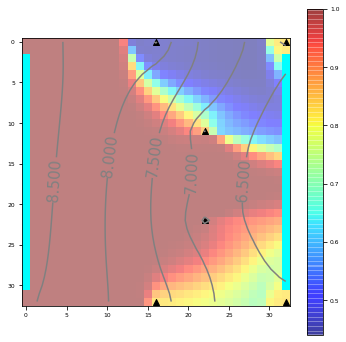

In [18]:
sim = flopy.mf6.MFSimulation.load(sim_ws="fivespot")
m = sim.get_model("gwf")
widx = [i[0] for i in m.get_package("wel").stress_period_data.data[1]]
hds = flopy.utils.HeadFile(os.path.join("fivespot","gwf.hds"))
ucn = flopy.utils.HeadFile(os.path.join("fivespot_t","gwt.ucn"),text="concentration")
fig,ax = plt.subplots(1,1,figsize=(6,6))
carr = ucn.get_data()[0]
carr[carr<=0.0001] = np.nan
c = ax.imshow(carr,cmap="jet",alpha=0.5)
plt.colorbar(c,ax=ax)
lb = ax.contour(hds.get_data()[0],levels=5,colors='0.5')
ax.clabel(lb,fontsize=15)
for w in widx:
    ax.scatter(w[2],w[1],marker="^",c="k")
garr = np.zeros((m.dis.nrow.data,m.dis.ncol.data))
for idx in m.get_package("ghb").stress_period_data.data[1]:
    garr[idx[0][1],idx[0][2]] = idx[2]
garr[garr == 0] = np.nan
ax.imshow(garr,cmap="cool")


We can see the effect of the flow balancing (compared to above) in the head contours.  We can also see the effect of the treatment effiency in the concentration distribution, especially near the injection wells.

Let's finish up by looking at the transport model CTS summary CSV files:

In [19]:
pd.read_csv(os.path.join("fivespot_t","gwt_cts_system_summary.csv"))

,stress_period,time_step,ctime,dt,cts_system,num_injectors,num_extractors,flow_rate,cum_vol,mass_removed,cum_mass_removed,mass_treated,cum_mass_treated,mass_injected,cum_mass_injected,concen_injected,requested_efficiency
0,2,1,360.0,180.0,1,1,1,74.884536,13479.216485,1795.361778,1795.361778,1098.761408,1098.761408,696.600370,696.600370,0.051680,0.612
1,2,1,360.0,180.0,2,3,1,73.373202,13207.176345,4352.148980,4352.148980,1031.459308,1031.459308,3320.689672,3320.689672,0.251431,0.237
2,3,1,540.0,180.0,1,1,1,74.636984,26913.873637,2391.346588,4186.708366,1042.627112,2141.388520,1348.719475,2045.319845,0.100391,0.436
3,3,1,540.0,180.0,2,3,1,73.118412,26368.490526,6298.754486,10650.903465,6298.754486,7330.213794,0.000000,3320.689672,0.000000,1.000
4,4,1,720.0,180.0,1,1,1,74.612308,40344.089143,3224.847502,7411.555868,951.330013,3092.718534,2273.517489,4318.837335,0.169284,0.295
5,4,1,720.0,180.0,2,3,1,73.093395,39525.301579,8509.985767,19160.889232,1778.587025,9108.800819,6731.398741,10052.088413,0.511628,0.209
6,5,1,900.0,180.0,1,1,1,74.609781,53773.849774,4892.796098,12304.351967,107.641514,3200.360048,4785.154584,9103.991919,0.356310,0.022
7,5,1,900.0,180.0,2,3,1,73.090846,52681.653833,9373.142672,28534.031904,5511.407891,14620.208710,3861.734781,13913.823194,0.293526,0.588
8,6,1,1080.0,180.0,1,1,1,71.686996,66677.509138,9423.589683,21727.941650,2252.237934,5452.597982,7171.351749,16275.343668,0.555761,0.239
9,6,1,1080.0,180.0,2,3,1,70.342494,65343.302692,12011.761186,40545.793090,5681.563041,20301.771751,6330.198145,20244.021339,0.499951,0.473
